# Using the `DeepGRU` classifier

This notebook aims to showcase how Sequentia's PyTorch implementation of recurrent neural networks (specifically the [DeepGRU](https://arxiv.org/abs/1810.12514) architecture) can be used in a typical sequence classisfication task. 

In particular, we look at the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset), which is an open dataset consisting of audio recordings of spoken digits from 0 to 9. We are interested in the task of determining which digit was spoken based on the audio recordings. Since audio signals are sequential data, we can consider this as a sequence classification problem.

In [1]:
import torch, torchaudio
from torch import utils, nn, optim
from torchfsdd import TorchFSDDGenerator
from torchaudio.transforms import MFCC
from torchvision.transforms import Compose

from sequentia.classifiers.rnn import DeepGRU, collate_fn

import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

To get started, we first decide to use [Mel-Frequency Cepstrum Coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a common way to represent audio for machine learning. 

While there are methods that work directly with raw signals, the most common approach is to use transformed features such as MFCCs.

In short, MFCCs are used to characterize a particular window (usually 20-40ms) of samples of the original signal, by applying signal processing techniques and transformations to obtain a number of representative coefficients. The signal is divided into windows (which may be overlapping), and MFCCs are computed for each one of these frames.

---

Below, we specify 5 MFCCs and create a transformation pipeline to generate and standardize them so that the coefficients for each window have zero mean and unit variance.

**Notes**: 

- We also transpose the MFCCs as `DeepGRU` expects a $B\times T\times D$ tensor, where $B$ is the batch size, $T$ is the number of frames of the longest recording, and $D$ is the number of MFCCs.
- 5 MFCCs is far less than what would be used in typical machine learning tasks, but we use a small number just for demonstration purposes.

In [2]:
# Set MFCC configuration
sr = 8000
n_mfcc = 5
spec_kwargs = {'n_fft': 1024, 'hop_length': 256, 'power': 2}

# Set number of classes
n_digits = 10

# Specify transformations to be applied to the raw audio
transforms = Compose([
    # Generate 3+1 MFCCs (and remove the first one since it is a constant offset)
    lambda audio: MFCC(sample_rate=sr, n_mfcc=n_mfcc+1, melkwargs=spec_kwargs)(audio)[1:],
    # Standardize MFCCs for each frame
    lambda mfcc: (mfcc - mfcc.mean(axis=0)) / mfcc.std(axis=0),
    # Transpose from DxT to TxD
    lambda mfcc: mfcc.transpose(1, 0)
])

The below code uses the [`torchfsdd`](https://github.com/eonu/torch-fsdd) package to load a local copy of the FSDD dataset into training and test set splits (80% and 20%, respectively).

The transformations are applied on the fly, whenever you index a recording in the dataset.

In [3]:
# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(version='local', path='recordings', transforms=transforms)

# Create two Torch datasets for a train-test split from the generator
train_set, test_set = fsdd.train_test_split(test_size=0.2)
print('Training set size: {}'.format(len(train_set)))
print('Test set size: {}'.format(len(test_set)))

Training set size: 2400
Test set size: 600


The figure below shows the difference between the raw audio signal of the pronunciation of a digit 3, and the MFCC representation.

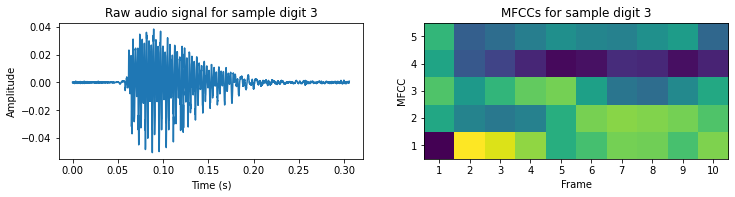

In [4]:
mfcc, digit = train_set[0]
audio, sr = torchaudio.load(train_set.files[0], channels_first=False)
time = np.linspace(0, len(audio) / sr, num=len(audio))

# Raw audio
fig, axs = plt.subplots(ncols=2, figsize=(12, 2.5))
axs[0].set(title='Raw audio signal for sample digit {}'.format(digit), xlabel='Time (s)', ylabel='Amplitude')
axs[0].plot(time, audio)

# MFCCs
axs[1].imshow(np.swapaxes(mfcc, 0, 1), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
axs[1].set(title='MFCCs for sample digit {}'.format(digit), xlabel='Frame', ylabel='MFCC',
    xticks=np.arange(len(mfcc)), xticklabels=np.arange(1, len(mfcc) + 1),
    yticks=np.arange(n_mfcc), yticklabels=np.arange(1, n_mfcc + 1))

plt.show()

We now create PyTorch data loaders using the previously defined PyTorch datasets, along with the `collate_fn` function provided by Sequentia. The data loaders group together recordings of similar duration into a single batch, as specified by `collate_fn`. 

We use a batch size of 64 for the training set, and use single batch for the test set.

In [5]:
# Create training, validation and test set batch iterators
train_gen = utils.data.DataLoader(train_set, collate_fn=collate_fn, batch_size=64, shuffle=True, num_workers=0)
test_gen = utils.data.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set), num_workers=0)

Next, we initialize the `DeepGRU` model by specifying the dimensions of the input, and the number of classes.

In [6]:
# Create a DeepGRU neural network model
model = DeepGRU(n_mfcc, n_digits)

At this stage if you wanted to specify a specific device such as a CUDA-supported GPU, you should do the following instead.

```python
model = DeepGRU(n_mfcc, n_digits, device='cuda:0')
```

Next, we specify the negative log-likelihood loss function (which is also the same as cross entropy) as the optimization criterion, and apply the Adam learning rule to optimize the model parameters. 

In [7]:
# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

We then run the typical PyTorch training loop for 10 epochs.

In [8]:
%%time

n_epoch = 10
for epoch in tqdm(range(n_epoch), desc='Epoch'):
    # Toggle training mode
    model.train()
    
    # Training loop
    for batch, lengths, labels in tqdm(train_gen, desc='Training batch', leave=False):
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Calculate predictions for batch
        log_prob = model(batch, lengths)
        y_pred = torch.argmax(log_prob, dim=1)
        
        # Calculate and back-propagate loss
        loss = criterion(log_prob, labels)
        loss.backward()
        
        # Update the optimizer
        optimizer.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

Training batch:   0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 6min 26s, sys: 1min 12s, total: 7min 38s
Wall time: 6min 13s


Finally, we apply the model to the test set in evaluation mode to obtain a test accuracy and confusion matrix.

In [9]:
# Toggle evaluation mode
model.eval()

# Retrieve test set as a single batch
batch, lengths, labels = next(iter(test_gen))

# Calculate predictions for test set
y = model(batch, lengths)
y_pred = torch.argmax(y, dim=1)

In [10]:
# Calculate accuracy
acc = torch.mean((labels == y_pred).float()).item()

# Calculate confusion matrix
classes = range(10)
cm = confusion_matrix(labels, y_pred, labels=classes)

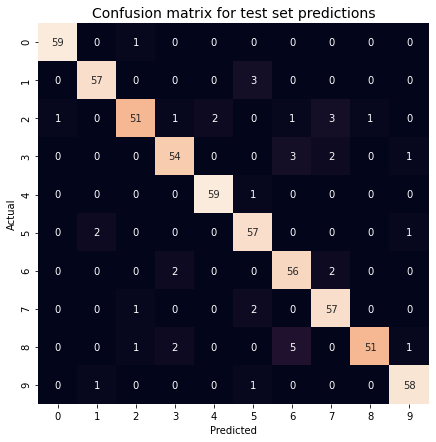

Accuracy: 93.17%


In [11]:
# Display accuracy and confusion matrix
df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(7, 7))
sns.heatmap(df, annot=True, cbar=False)
plt.title('Confusion matrix for test set predictions', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('Accuracy: {:.2f}%'.format(acc * 100))